# NLP in Recommender Systems

Welcome to the second lecture of the Machine Learning Fortnight! It will be a more practical lecture, where you will get to see how to process the data, analyse it and apply recommedation systems. We will go through the collaborative filtering and content-based filtering techniques.

You can copy this code to use for the competition. You can also use it as a reference for your future projects. By no means is this the only way to do it, but it is a good starting point.

For this assignment, we will use the anime recommedation dataset from [Kaggle](https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020). The dataset contains information about anime, users and their ratings. The goal is to predict the rating that a user would give to an anime that they have not yet rated.

In [ ]:
!pip install transformers torch

In [106]:
# !curl 

# unzip dataset
!unzip -q anime-recommendation-database-2020.zip -d data/

replace data/anime.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [2]:
import pandas as pd                 # pandas is a dataframe library
import numpy as np                  # numpy provides N-dim object support
import matplotlib.pyplot as plt     # matplotlib.pyplot plots data
import seaborn as sns               # seaborn is the big brother of matplotlib
import os                           # os handles directory/workspace changes
from tqdm import tqdm_notebook      # tqdm_notebook is the progress bar library

from sklearn.model_selection import train_test_split # to split out training and testing data
from sklearn.preprocessing import LabelEncoder       # to convert labels into numbers
from sklearn.metrics import mean_absolute_error      # for mean absolute error

import tensorflow as tf             # tensorflow is the machine learning library we will be using


# ––––––––––––––––––––––––
#           Setup
# ––––––––––––––––––––––––

pd.set_option('display.max_columns', 100) # Display up to 100 columns of a dataframe
pd.set_option('display.max_rows', 100)    # Display up to 100 rows of a dataframe

## Data Analysis and Preprocessing

### Ratings File

The `rating_complete.csv` file contains the ratings of the users. Each row is a pair of user and anime and rating (0-10).

In [3]:
ratings = pd.read_csv("./data/rating_complete.csv")
ratings.head()

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


Text(0, 0.5, 'Count')

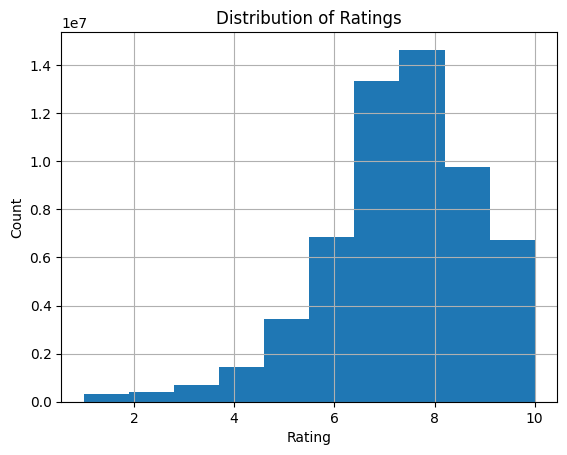

In [4]:
ratings.rating.hist()
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

In [5]:
# let's normalize the ratings (0, 1)
ratings["rating"] = ratings["rating"] / 10.0

Let's anaylse how many ratings have people given.

Text(0, 0.5, 'Count of users')

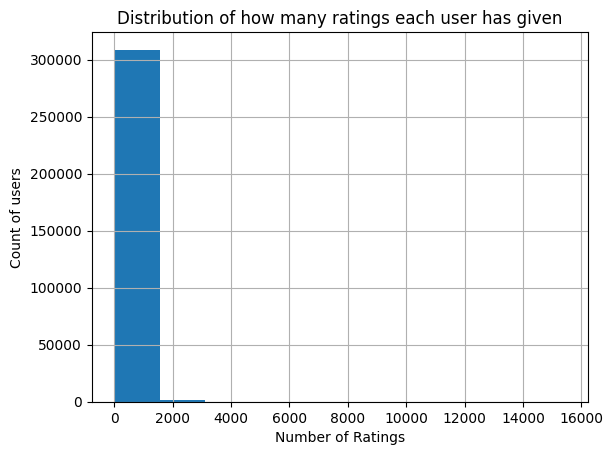

In [6]:
ratings.user_id.value_counts().hist()
plt.title('Distribution of how many ratings each user has given')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of users')

Appears someone has given out 160k ratings.

Let's assume that an anime is 12 episodes long and each episode is 24 minutes long. Then, time taken to watch 160k anime is
$160k * (24 * 12) / (60) = 768000$ hours of non-stop watch of anime. If this person daily watched 8 hours of anime non-stop, then it would take them 264 years. What is possible, but quite unlikely))).

Reasonably, the maximum would be 10k hours of anime, which is 1 year and 2 months of non-stop anime watching.

This is approximately $10k * 60 / (24 * 12) = 2084$ anime. So, let's remove the users who have rated more than 2084 animes. Most likely, they are bots.

In [7]:
# get list of users who have rated more than 2084 anime
bot_users = ratings.user_id.value_counts() > 2084
bot_users = bot_users[bot_users == True].index

# remove bot users from ratings dataframe
ratings = ratings[~ratings.user_id.isin(bot_users)]

Text(0, 0.5, 'Count of users')

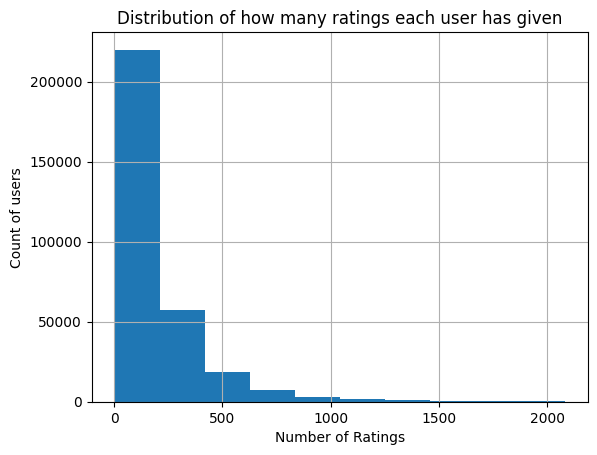

In [8]:
ratings.user_id.value_counts().hist()
plt.title('Distribution of how many ratings each user has given')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of users')

This is still crazy, but more reasonable. Weebs...

Let's also remove the users who have rated less than 40 animes. They are not weebs enough. And animes that have been rated less than 40 times. They are not popular enough.

It would be difficult to work with such users and animes, because there is not enough data to make a good prediction.

We will use the average anime rating for them as prediction.

In [9]:
prev_size = ratings.shape[0]

min_ratings = 40

while True:
    # get list of users who have rated less than 40 anime (min_ratings)
    not_weeb_users = ratings.user_id.value_counts() < min_ratings
    not_weeb_users = not_weeb_users[not_weeb_users == True].index

    # get list of animes which have been rated less than 40 times (min_ratings)
    not_popular_anime = ratings.anime_id.value_counts() < min_ratings
    not_popular_anime = not_popular_anime[not_popular_anime == True].index

    # remove them
    ratings = ratings[~ratings.user_id.isin(not_weeb_users)]
    ratings = ratings[~ratings.anime_id.isin(not_popular_anime)]

    if ratings.shape[0] == prev_size:
        break
    else:
        prev_size = ratings.shape[0]

ratings.shape

(54838734, 3)

Let's encode the user and anime ids to be from 0 to N-1, where N is the number of users and animes respectively.

In [10]:
user_enc = LabelEncoder()
ratings["user_enc_id"] = user_enc.fit_transform(ratings["user_id"].values)

anime_enc = LabelEncoder()
ratings["anime_enc_id"] = anime_enc.fit_transform(ratings["anime_id"].values)

### Anime File

The `anime_with_synopsis.csv` file contains information about the anime. Each row is an anime and its information.

In [11]:
anime = pd.read_csv("./data/anime_with_synopsis.csv")
anime.columns = ['anime_id', 'name', 'average_rating', 'genres', 'synopsis']
anime.head()

,anime_id,name,average_rating,genres,synopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [12]:
# difference between animes (if there are animes not present in ratings)
anime_not_present = len(set(ratings.anime_id.unique()) - set(anime.anime_id.unique()))

print("There are {} animes present in ratings that are not present in anime".format(anime_not_present))
print("There are {} animes in anime_with_synopsis.csv".format(anime.shape[0]))
print("There are {} animes in rating_complete.csv".format(ratings.anime_id.nunique()))

There are 1221 animes present in ratings that are not present in anime
There are 16214 animes in anime_with_synopsis.csv
There are 11260 animes in rating_complete.csv


Let's make the genres column into a list of genres.

In [13]:
# geners to dummy variables
anime = anime.join(anime.genres.str.get_dummies(sep=','))

# drop genres column
anime.drop('genres', axis=1, inplace=True)

# format the columns to lowercase and remove spaces
anime.columns = anime.columns \
    .str.strip() \
    .str.lower() \
    .str.replace(' ', '_') \
    .str.replace('-', '_') \
    

anime.head()

,anime_id,name,average_rating,synopsis,adventure,cars,comedy,dementia,demons,drama,ecchi,fantasy,game,harem,historical,horror,josei,kids,magic,martial_arts,mecha,military,music,mystery,parody,police,psychological,romance,samurai,school,sci_fi,seinen,shoujo,shoujo_ai,shounen,shounen_ai,slice_of_life,space,sports,super_power,supernatural,thriller,vampire,yaoi,action,adventure,cars,comedy,dementia,demons,drama,ecchi,fantasy,game,harem,historical,horror,josei,kids,magic,martial_arts,mecha,military,music,mystery,parody,police,psychological,romance,samurai,school,sci_fi,seinen,shoujo,shounen,shounen_ai,slice_of_life,space,sports,super_power,supernatural,thriller,unknown,vampire,yaoi
0,1,Cowboy Bebop,8.78,"In the year 2071, humanity has colonized sever...",1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"other day, another bounty—such is the life of ...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,Trigun,8.24,"Vash the Stampede is the man with a $$60,000,0...",1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,7,Witch Hunter Robin,7.27,ches are individuals with special powers like ...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,Bouken Ou Beet,6.98,It is the dark century and the people are suff...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Train-Test Split

Let's split the data into train and test sets. We will use the train set to train the model and the test set to evaluate the model.

In [14]:
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42, stratify=ratings['user_enc_id'])

## Results table

Let's create a table to store the results of the models.

In [15]:
results = pd.DataFrame(columns=['Model', 'test_MAE'])

def add_res(model_name, test_mae):
    global results
    results = pd.concat([results, pd.DataFrame([[model_name, test_mae]], columns=['Model', 'test_MAE'])])
    display(results.sort_values(by=['test_MAE']))

## Baselines

There are some baseline models that we can implement which will give us a good starting point.

### User Average

The first baseline is the average rating of the user. It is the average rating that the user has given to all animes. If the user has not rated any animes, then we use the average rating of all users.

### Anime Average

The second baseline is the average rating of the anime. It is the average rating that the anime has received from all users. If the anime has not been rated by any user, then we use the average rating of all animes.

In [120]:
# implement a model to try user average rating

class UserAverageRating:
    def __init__(self):
        self.user_averages = None
        self.global_average = None

    def fit(self, X, y):
        self.global_average = np.mean(y)

        print("Calculating user averages...")
        self.user_averages = X.groupby('user_enc_id')['rating'].mean()

    def predict(self, X):
        print("Predicting...")
        y_pred = []
        for user_id in tqdm_notebook(X.user_enc_id):
            if user_id in self.user_averages.index:
                y_pred.append(self.user_averages[user_id])
            else:
                y_pred.append(self.global_average)

        return np.array(y_pred)
    
user_average_rating = UserAverageRating()
user_average_rating.fit(train_ratings, train_ratings.rating)

y_pred = user_average_rating.predict(test_ratings)

mae = mean_absolute_error(test_ratings.rating, y_pred)

add_res('User Average Rating', mae)

Calculating user averages...
Predicting...


/var/folders/w3/2rfcg8md39x8h72m0ssfy9n80000gn/T/ipykernel_2000/880824483.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm_notebook(X.user_enc_id):


  0%|          | 0/10967747 [00:00<?, ?it/s]

/var/folders/w3/2rfcg8md39x8h72m0ssfy9n80000gn/T/ipykernel_2000/3472409501.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([[model_name, test_mae]], columns=['Model', 'test_MAE'])])


,Model,test_MAE
0,User Average Rating,0.109


In [121]:
class AnimeAverageRating:
    def __init__(self):
        self.anime_averages = None
        self.global_average = None

    def fit(self, X, y):
        self.global_average = np.mean(y)

        print("Calculating anime averages...")
        self.anime_averages = X.groupby('anime_enc_id')['rating'].mean()

    def predict(self, X):
        print("Predicting...")
        y_pred = []
        for anime_id in tqdm_notebook(X.anime_enc_id):
            if anime_id in self.anime_averages.index:
                y_pred.append(self.anime_averages[anime_id])
            else:
                y_pred.append(self.global_average)

        return np.array(y_pred)
    
anime_average_rating = AnimeAverageRating()
anime_average_rating.fit(train_ratings, train_ratings.rating)

y_pred = anime_average_rating.predict(test_ratings)

mae = mean_absolute_error(test_ratings.rating, y_pred)

add_res('Anime Average Rating', mae)

Calculating anime averages...
Predicting...


/var/folders/w3/2rfcg8md39x8h72m0ssfy9n80000gn/T/ipykernel_2000/697480741.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for anime_id in tqdm_notebook(X.anime_enc_id):


  0%|          | 0/10967747 [00:00<?, ?it/s]

,Model,test_MAE
0,User Average Rating,0.109
0,Anime Average Rating,0.114


Ok, that's pretty good. Let's try to do better.

## Collaborative Filtering

### Stochastic Gradient Descent

For collaborative we will use matrix factorization, in TensorFlow with gradient descent.

We will use the following formula for the prediction:
$$
\hat{r}_{u,i} = \mu + b_u + b_i + q_i^Tp_u
$$

where $\mu$ is the average rating, $b_u$ is the user bias, $b_i$ is the anime bias, $q_i$ is the anime embedding and $p_u$ is the user embedding.

We will use the following loss function:
$$
L = \sum_{u,i} (r_{u,i} - \hat{r}_{u,i})^2 + \lambda_1(||q_i||^2 + ||p_u||^2) + \lambda_2(b_i^2 + b_u^2)
$$

where $\lambda_1$, $\lambda_2$ are the regularization parameters.

In [122]:
from tensorflow.keras.regularizers import l2

class MatrixFactorizationModel(tf.keras.Model):
    def __init__(self, num_users, num_items, embedding_dim, l2_emb, l2_bias):
        super(MatrixFactorizationModel, self).__init__()
        
        self.embedding_dim = embedding_dim
        
        self.user_emb = tf.keras.layers.Embedding(num_users, embedding_dim, embeddings_regularizer=l2(l2_emb))
        self.item_emb = tf.keras.layers.Embedding(num_items, embedding_dim, embeddings_regularizer=l2(l2_emb))

        self.user_bias = tf.keras.layers.Embedding(num_users, 1, embeddings_regularizer=l2(l2_bias))
        self.item_bias = tf.keras.layers.Embedding(num_items, 1, embeddings_regularizer=l2(l2_bias))

        self.bias = tf.Variable(tf.zeros([1]))

    def call(self, inputs):
        user_ids = inputs[:, 0]
        item_ids = inputs[:, 1]

        user_emb = self.user_emb(user_ids)
        item_emb = self.item_emb(item_ids)
        user_bias = self.user_bias(user_ids)
        item_bias = self.item_bias(item_ids)

        user_emb = tf.reshape(user_emb, [-1, self.embedding_dim])
        item_emb = tf.reshape(item_emb, [-1, self.embedding_dim])

        rating_pred = tf.keras.layers.Dot(axes=1)([user_emb, item_emb])
        rating_pred = tf.add(rating_pred, self.bias)
        rating_pred = tf.add(rating_pred, user_bias)
        rating_pred = tf.add(rating_pred, item_bias)

        return rating_pred

In [123]:
num_users = ratings.user_enc_id.nunique()
num_anime = ratings.anime_enc_id.nunique()

mf_model = MatrixFactorizationModel(num_users = num_users, 
                                    num_items = num_anime, 
                                    embedding_dim = 64,
                                    l2_emb  = 0.1,
                                    l2_bias = 0.01)

mf_model.compile(
    optimizer = tf.keras.optimizers.legacy.Adam(),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [
        tf.keras.metrics.MeanAbsoluteError("MAE")
    ]
)

In [124]:
hist = mf_model.fit(
    x = train_ratings[["user_enc_id", "anime_enc_id"]].values,
    y = train_ratings["rating"].values,
    batch_size = 500_000, # this is quite big, but it will run faster
    epochs = 10,
    verbose = 1,
    validation_split = 0.1
)

Epoch 1/10
79/79 [==============================] - 28s 332ms/step - loss: 233.8380 - MAE: 0.6958 - val_loss: 0.7482 - val_MAE: 0.6457
Epoch 2/10
79/79 [==============================] - 25s 313ms/step - loss: 0.4640 - MAE: 0.6070 - val_loss: 0.3697 - val_MAE: 0.5700
Epoch 3/10
79/79 [==============================] - 21s 264ms/step - loss: 0.3322 - MAE: 0.5373 - val_loss: 0.2963 - val_MAE: 0.5050
Epoch 4/10
79/79 [==============================] - 18s 223ms/step - loss: 0.2654 - MAE: 0.4754 - val_loss: 0.2358 - val_MAE: 0.4459
Epoch 5/10
79/79 [==============================] - 27s 341ms/step - loss: 0.2106 - MAE: 0.4190 - val_loss: 0.1864 - val_MAE: 0.3923
Epoch 6/10
79/79 [==============================] - 23s 281ms/step - loss: 0.1661 - MAE: 0.3677 - val_loss: 0.1468 - val_MAE: 0.3434
Epoch 7/10
79/79 [==============================] - 23s 281ms/step - loss: 0.1306 - MAE: 0.3219 - val_loss: 0.1154 - val_MAE: 0.3006
Epoch 8/10
79/79 [==============================] - 21s 261ms/step 

In [125]:
y_pred = mf_model.predict(test_ratings[["user_enc_id", "anime_enc_id"]].values)

mae = mean_absolute_error(test_ratings.rating, y_pred)

add_res('Matrix Factorization', mae)

342743/342743 [==============================] - 161s 470us/step


,Model,test_MAE
0,User Average Rating,0.109
0,Anime Average Rating,0.114
0,Matrix Factorization,0.205


Probably the model is not completely converged, might need to run longer to get better results.

### Alternating Least Squares

For collaborative we will use matrix factorization, in TensorFlow with alternating least squares. It is similar to gradient descent, but it is faster. It is also a bit more difficult to implement.

We will use the following formula for the prediction:
$$
\hat{r}_{u,i} = q_i^Tp_u
$$

where $q_i$ is the anime embedding and $p_u$ is the user embedding. We will not use the biases, because they are not needed.

We will use the following loss function:
$$
L = \sum_{u,i} (r_{u,i} - \hat{r}_{u,i})^2.
$$

This can be optimized using alternating least squares. First, we optimize $p_u$ while keeping $q_i$ fixed. Then, we optimize $q_i$ while keeping $p_u$ fixed. We repeat this until convergence.


In [129]:
class MatrixFactorizationModel_ALS(tf.keras.Model):
    def __init__(self, num_users, num_items, embedding_dim):
        super(MatrixFactorizationModel_ALS, self).__init__()
        
        self.embedding_dim = embedding_dim
    
        self.user_emb = tf.keras.layers.Embedding(num_users, embedding_dim)
        self.item_emb = tf.keras.layers.Embedding(num_items, embedding_dim)

    def call(self, inputs):
        user_ids = inputs[:, 0]
        item_ids = inputs[:, 1]

        user_emb = self.user_emb(user_ids)
        item_emb = self.item_emb(item_ids)
        
        user_emb = tf.reshape(user_emb, [-1, self.embedding_dim])
        item_emb = tf.reshape(item_emb, [-1, self.embedding_dim])

        rating_pred = tf.keras.layers.Dot(axes=1)([user_emb, item_emb])

        return rating_pred
    
    def custom_fit(self, epochs, x, y):
        for epoch in range(epochs):
            print("Epoch {}/{} |".format(epoch+1, epochs), end="\t")
            self.user_emb.trainable = epoch % 2 == 0
            self.item_emb.trainable = epoch % 2 == 1

            self.fit(
                x = x,
                y = y,
                batch_size = 500_000,
                epochs = 1,
                verbose = 1,
                shuffle = True
            )

In [130]:
als_model = MatrixFactorizationModel_ALS(
    num_users = num_users,
    num_items = num_anime,
    embedding_dim = 64)

# compile the model
als_model.compile(
    optimizer = tf.keras.optimizers.legacy.Adam(),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [
        tf.keras.metrics.MeanAbsoluteError("MAE")
    ]
)

als_model.custom_fit(
    epochs = 10,
    x = train_ratings[["user_enc_id", "anime_enc_id"]].values,
    y = train_ratings["rating"].values
)

88/88 [==============================] - 40s 432ms/step - loss: 0.0139 - MAE: 0.0889


In [131]:
y_pred = als_model.predict(test_ratings[["user_enc_id", "anime_enc_id"]].values)

mae = mean_absolute_error(test_ratings.rating, y_pred)

add_res('Matrix Factorization ALS', mae)

342743/342743 [==============================] - 146s 427us/step


,Model,test_MAE
0,Matrix Factorization ALS,0.089
0,User Average Rating,0.109
0,Anime Average Rating,0.114
0,Matrix Factorization,0.205


## Content-Based Filtering

For content-based filtering we will use the genres of the anime, and BERT embeddings of the synopsis. We will use the embedding to find the similarity between the animes. Then, we will use the similarity to find the rating of the anime.

We will use the following formula for the prediction:

$$
\hat{r}_{u,i} = \frac{\sum_{j \in N_i} s_{i,j} r_{u,j}}{\sum_{j \in N_i} s_{i,j}}
$$

where $N_i$ is the set of animes similar to anime $i$ and $s_{i,j}$ is the similarity between anime $i$ and anime $j$.

### Genres

Let's make a model where each user is an average of the genres of the animes that they have rated. Then, we will use the genres of the anime to predict the rating.

In [ ]:
# ––
# THIS IS MOST INEFFICIENT WAY TO DO THIS
# THINK MAYBE HOW TO PARALLELIZE THIS
# BY CHANGING THE FOR LOOP TO LINEAR ALGEBRA
# ––

class GenresSimRating:
    def __init__(self):
        self.user_emb = {}
        self.user_mean = None

    def fit(self, X, y):
        print("Calculating user embeddings...")
        self.user_mean = X.groupby('user_enc_id')['rating'].mean()
        
        for user_id, group in tqdm_notebook(X.groupby('user_enc_id')):
            selection = anime.anime_id.isin(group.anime_id)
            if selection.sum() == 0:
                continue
            emb = anime[selection].iloc[:, 4:].mean()
            self.user_emb[user_id] = emb / np.linalg.norm(emb)

    def predict(self, X):
        print("Predicting...")
        y_pred = []

        for user_id, anime_id in tqdm_notebook(zip(X.user_enc_id, X.anime_enc_id), total=X.shape[0]):
            if user_id in self.user_emb and anime_id in anime.index:
                user_emb = self.user_emb[user_id]
                anime_emb = anime.iloc[anime_id][4:]
                cos_sim = np.dot(user_emb, anime_emb) / np.linalg.norm(anime_emb)
                y_pred.append(cos_sim)
            else:
                y_pred.append(self.user_mean[user_id])

        return np.array(y_pred)
    
genre_sim_rating = GenresSimRating()
genre_sim_rating.fit(train_ratings, train_ratings.rating)

y_pred = genre_sim_rating.predict(test_ratings)

mae = mean_absolute_error(test_ratings.rating, y_pred)

add_res('Genre Similiraty Rating', mae)

### BERT Embeddings

BERT is a language model that can be used to get embeddings of text. We will use it to get embeddings of the synopsis of the anime. Then, we will use the embeddings to find the similarity between the animes. We will use the cosine similarity.

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

def bert_embed_parallel(texts, batch_size=32):
    # Load pre-trained model tokenizer (vocabulary)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Load pre-trained model
    model = BertModel.from_pretrained('bert-base-uncased')

    # Process texts in batches
    all_embeddings = []
    for i in tqdm_notebook(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]

        # Tokenize and pad the batch
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt")

        # Get embeddings with no gradient computation
        with torch.no_grad():
            outputs = model(**inputs)

        # Compute the mean of the last hidden states for each input in the batch
        embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
        all_embeddings.extend(embeddings)

    return np.array(all_embeddings)

# Example usage
texts = list(anime.synopsis.values)
embedded_texts = bert_embed_parallel(texts)

# save the embeddings
np.save('bert_embeddings.npy', embedded_texts)

We will make a similar model as with the genres, but instead of using the genres, we will use the embeddings.

In [ ]:
# ––
# THIS IS MOST INEFFICIENT WAY TO DO THIS
# THINK MAYBE HOW TO PARALLELIZE THIS
# BY CHANGING THE FOR LOOP TO LINEAR ALGEBRA
# ––

class BertSimRating:
    def __init__(self):
        self.user_emb = {}
        self.user_mean = None

    def fit(self, X, y):
        print("Calculating user embeddings...")
        self.user_mean = X.groupby('user_enc_id')['rating'].mean()
        
        for user_id, group in tqdm_notebook(X.groupby('user_enc_id')):
            selection = anime.anime_id.isin(group.anime_id)
            if selection.sum() == 0:
                continue
            emb = embedded_texts[selection].mean(axis=0)
            self.user_emb[user_id] = emb / np.linalg.norm(emb)

    def predict(self, X):
        print("Predicting...")
        y_pred = []

        for user_id, anime_id in tqdm_notebook(zip(X.user_enc_id, X.anime_enc_id), total=X.shape[0]):
            if user_id in self.user_emb and anime_id in anime.index:
                user_emb = self.user_emb[user_id]
                anime_emb = embedded_texts[anime_id]
                cos_sim = np.dot(user_emb, anime_emb) / np.linalg.norm(anime_emb)
                y_pred.append(cos_sim)
            else:
                y_pred.append(self.user_mean[user_id])

        return np.array(y_pred)

In [ ]:
bert_sim_rating = BertSimRating()
bert_sim_rating.fit(train_ratings, train_ratings.rating)

y_pred = bert_sim_rating.predict(test_ratings)

mae = mean_absolute_error(test_ratings.rating, y_pred)

add_res('BERT Similiraty Rating', mae)